In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
from datetime import date
from datetime import datetime


%matplotlib inline
np.random.seed(42)

df = pd.read_csv('homepage_actions.csv')

# I converted action to either True of False for easier calcuation
df['action'] = df['action'].map({'click':True ,'view':False})


df.head()
#df.count()
#df.describe()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,False
1,2016-09-24 19:19:03.542569,434745,experiment,False
2,2016-09-24 19:36:00.944135,507599,experiment,False
3,2016-09-24 19:59:02.646620,671993,control,False
4,2016-09-24 20:26:14.466886,536734,experiment,False


## Your task is to analyze these actions to see if there was significant difference in performance of the two versiosns.

### 1. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.

$$H_0: $$ The new version is the same as the old version.
$$H_1: $$ The new version is better than the old version

### 2. Find the total number of actions 

In [456]:
print(df.group.unique(), 'are the groups')
print(df.action.unique(), 'are the types')
#print( df[df['action'] == 'view'] ) # 6328

print(df.groupby('group').count()) 

['experiment' 'control'] are the groups
[False  True] are the types
            timestamp    id  action
group                              
control          4264  4264    4264
experiment       3924  3924    3924


### 3. Find the number of unique users

In [457]:
cnt = 0
uniqId = []
  
for i in range(0, len(df['id'])):
    if df['id'][i] not in uniqId: 
        uniqId.append(df['id'][i])          
        cnt += 1
        
print('number unique values: ', cnt)



number unique values:  6328


### 4. Find the sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [458]:
#print(df[df['group'] == 'experiment']) # 3924
#print(df[df['group'] == 'control']) # 4264

df.sort_values('id', inplace=True)
df.drop_duplicates(subset='id', inplace=True)
print(df.count())

print(df[df['group'] == 'experiment'].count()) # experiment count: 2996
print(df[df['group'] == 'control'].count()) # control count: 3332


timestamp    6328
id           6328
group        6328
action       6328
dtype: int64
timestamp    2996
id           2996
group        2996
action       2996
dtype: int64
timestamp    3332
id           3332
group        3332
action       3332
dtype: int64


### 5. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [459]:
df.sort_values('timestamp', inplace=True)
firstDay = df.iloc[0]['timestamp']
lastDay = df.iloc[len(df)-1]['timestamp']

date_format_str = '%Y-%m-%d %H:%M:%S.%f'

date_1 = firstDay
date_2 = lastDay

start = datetime.strptime(date_1, date_format_str)
end =   datetime.strptime(date_2, date_format_str)

diff = end - start

# Get interval between two timstamps as timedelta object
diff_in_hours = diff.total_seconds() / 3600
print("diff in hours: ", diff_in_hours)

# get the difference between two dates as timedelta object
diff = end.date() - start.date()
print("diff in days: ", diff.days)

diff in hours:  2776.6946638419445
diff in days:  116


### 6. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [460]:
print(df.action.unique(), 'are the types')
print(df.groupby('action').count())

[False  True] are the types
        timestamp    id  group
action                        
False        5390  5390   5390
True          938   938    938


### 7. Compute the click-through rate for each group.

In [461]:
# CTR: # clicks by unique users / # views by unique users 

print(df[df['action'] == True].mean())

view = df[df['action'] == 'view']
click = df[df['action'] == 'click']

vExp = view[view['group'] == 'experiment'] 
vCon = view[view['group'] == 'control']

cExp = click[click['group'] == 'experiment'] 
cCon = click[click['group'] == 'control']

#rExp = len(cExp) / len(vExp)
#rCon = len(cCon) / len(vCon)

print("the CTR for experiment: ", rExp *100 )
print("the CTR for control: ", rCon * 100 )

id        568110.623667
action         1.000000
dtype: float64
the CTR for experiment:  17.95275590551181
the CTR for control:  16.912280701754387


C:\Users\mikes\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### 8. Find the difference in click-through rate between the two groups.

In [462]:
diff = rExp - rCon
print("the diff of the rate is: ", diff * 100)

# % of cliks
df.action.mean()

the diff of the rate is:  1.0404752037574239


0.14823008849557523

### 9. Use bootstraping to simulate the sampling distribution for the difference in proportions.

In [467]:
sample_data = df.sample(200)
exper, control, diffs = [], [], []
for _ in range(10000):
    bootsamp = sample_data.sample(200, replace = True)
    
    exper_mean = bootsamp[bootsamp['group'] == 'experiment']['action'].mean()
    control_mean = bootsamp[bootsamp['group'] == 'control']['action'].mean()

    diffs.append(control_mean - exper_mean)
    
print("total mean: " , df['action'].mean() * 100)
print("control mean: " , control_mean * 100)
print("expremient mean: " ,exper_mean * 100)


total mean:  14.823008849557523
control mean:  14.150943396226415
expremient mean:  4.25531914893617


### 10. Simulate the null distribution with a mean of zero and use the standard deviation from the sampling distribution obtained in the prevous step.

In [464]:
low, high = np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)
print(low, high)

-0.1322140807830783 0.03636363636363635


### 11. Find the p-value

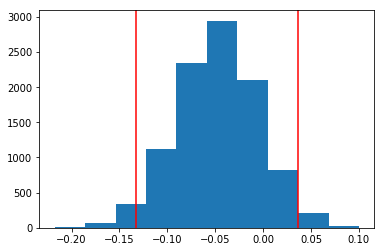

In [465]:
plt.hist(diffs);
plt.axvline(x=low, color = 'red')
plt.axvline(x=high, color = 'red');


### 12. Assuming your alpha is 5% shall you accept or reject the null hypothesis?

(-0.08382950822192518, 0.0860191545455714)

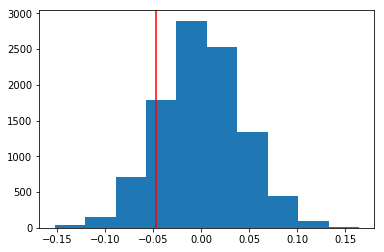

In [466]:
null_vals = np.random.normal(0, np.std(diffs), 10000) 
plt.hist(null_vals)
plt.axvline(x=np.mean(diffs), color = 'red')
np.percentile(null_vals, 2.5), np.percentile(null_vals, 97.5)


We reject the aletrnative hypothesis, the difference between the experimental group and the control group is not enough of a difference to make it matter.  So we accept the null hypothesis and decide that the difference in websites is not enought to get more people to click. The difference between the rates is only 1% and not enough to reject the 5& we decided we would use.